# Prioror tests and data preparation

Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import truncnorm, beta, norm, uniform
import matplotlib.pyplot as plt
import os
import mne

## Plots of priors' distributions

### Ter (non-decision time)

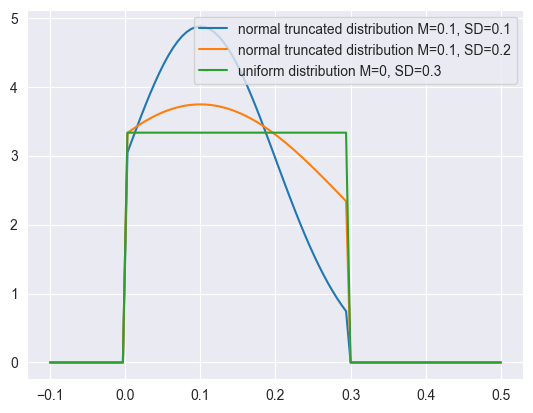

In [2]:
lower_boundary = 0
upper_boundary = 0.3
ter_mean = 0.1
ter_std = 0.1

x_range = np.linspace(-0.1, 0.5, 100)
a, b = (lower_boundary - ter_mean) / ter_std, (upper_boundary - ter_mean) / ter_std
ter = truncnorm.pdf(x_range, a, b, loc=ter_mean, scale=ter_std)
plt.plot(x_range,ter, label = f'normal truncated distribution M={ter_mean}, SD={ter_std}')

ter_mean = 0.1
ter_std = 0.2

x_range = np.linspace(-0.1, 0.5, 100)
a, b = (lower_boundary - ter_mean) / ter_std, (upper_boundary - ter_mean) / ter_std
ter = truncnorm.pdf(x_range, a, b, loc=ter_mean, scale=ter_std)
plt.plot(x_range,ter, label = f'normal truncated distribution M={ter_mean}, SD={ter_std}')

ter_mean = 0
ter_std = 0.3
ter = uniform.pdf(x_range, loc=ter_mean, scale=ter_std)
plt.plot(x_range,ter, label = f'uniform distribution M={ter_mean}, SD={ter_std}')

plt.legend()

### Alpha (threshold)

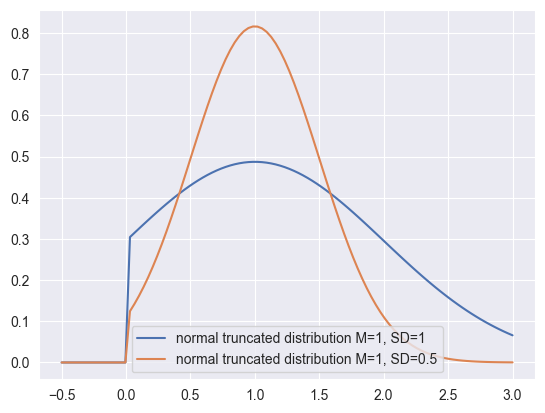

In [40]:
lower_boundary = 0
upper_boundary = 3
alpha_mean = 1
alpha_std = 1

x_range = np.linspace(-0.5, 3, 100)
a, b = (lower_boundary - alpha_mean) / alpha_std, (upper_boundary - alpha_mean) / alpha_std
alpha = truncnorm.pdf(x_range, a, b, loc=alpha_mean, scale=alpha_std)
plt.plot(x_range,alpha, label = f'normal truncated distribution M={alpha_mean}, SD={alpha_std}')

alpha_mean = 1
alpha_std = 0.5

x_range = np.linspace(-0.5, 3, 100)
a, b = (lower_boundary - alpha_mean) / alpha_std, (upper_boundary - alpha_mean) / alpha_std
alpha = truncnorm.pdf(x_range, a, b, loc=alpha_mean, scale=alpha_std)
plt.plot(x_range,alpha, label = f'normal truncated distribution M={alpha_mean}, SD={alpha_std}')

plt.legend()

### Beta (bias)

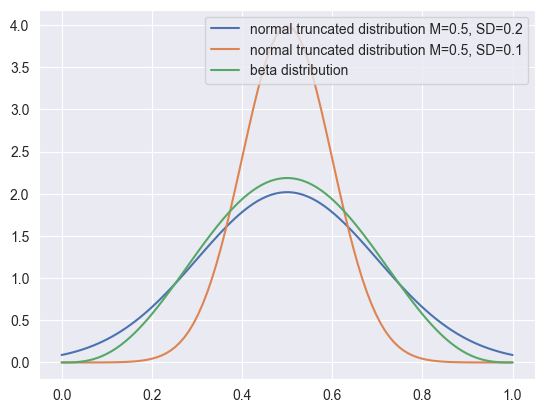

In [41]:
lower_boundary = 0
upper_boundary = 1
beta_mean = 0.5
beta_std = 0.2

x_range = np.linspace(0, 1, 100)
a, b = (lower_boundary - beta_mean) / beta_std, (upper_boundary - beta_mean) / beta_std
beta_ = truncnorm.pdf(x_range, a, b, loc=beta_mean, scale=beta_std)
plt.plot(x_range,beta_, label=f'normal truncated distribution M={beta_mean}, SD={beta_std}')

beta_mean = 0.5
beta_std = 0.1

x_range = np.linspace(0, 1, 100)
a, b = (lower_boundary - beta_mean) / beta_std, (upper_boundary - beta_mean) / beta_std
beta_ = truncnorm.pdf(x_range, a, b, loc=beta_mean, scale=beta_std)
plt.plot(x_range,beta_, label=f'normal truncated distribution M={beta_mean}, SD={beta_std}')

beta_beta = beta.pdf(x_range, a=4, b=4)
plt.plot(x_range,beta_beta, label='beta distribution')

plt.legend()

### Delta (drift rate)

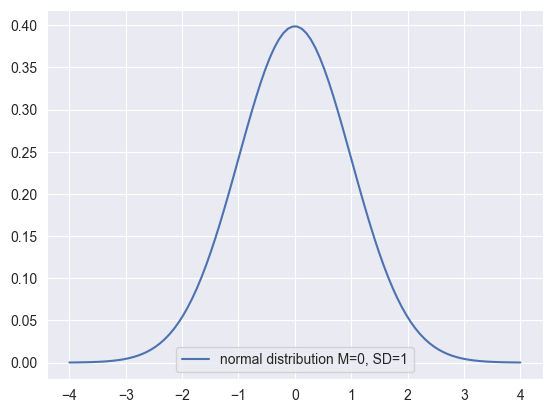

In [42]:
delta_mean = 0
delta_std = 1

x_range = np.linspace(-4, 4, 100)
delta = norm.pdf(x_range, loc=delta_mean, scale=delta_std)
plt.plot(x_range, delta, label=f'normal distribution M={delta_mean}, SD={delta_std}')

plt.legend()

## Read and prepare data

In [43]:
paradigm = 'FLA'
case = 'RE'

data_path = f'data/beh_eeg_{paradigm}/{paradigm}/preprocessed/wavelets_th-045/'
data_df = pd.DataFrame()

id_list = [item.split('.')[0] for item in os.listdir(data_path)][:25]

for participant_id in id_list:
    participant_data_df = pd.read_pickle(f'{data_path}{participant_id}.pkl')
    participant_data_df['ID'] = participant_id.split("_")[1]
    data_df = pd.concat([data_df, participant_data_df], ignore_index=True)

Featurize ERN: peak amplitude at FCz
- EEG column in bad trials will be filled with NaN

In [44]:
channel = 'FCz'

data_df[f'ne_{channel}'] = data_df.apply(
    lambda row: np.min(row['epoch'].get_data(picks=channel, tmin=0.0, tmax=0.1).flatten()) if channel not in row['drop_log'] else np.nan, 
    axis=1
)

data_df[f'ne_mean_{channel}'] = data_df.apply(
    lambda row: np.mean(row['epoch'].get_data(picks=channel, tmin=0.0, tmax=0.1).flatten()) if channel not in row['drop_log'] else np.nan,
    axis=1
)

channel = 'Fz'

data_df[f'ne_{channel}'] = data_df.apply(
    lambda row: np.min(row['epoch'].get_data(picks=channel, tmin=0.0, tmax=0.1).flatten()) if channel not in row['drop_log'] else np.nan,
    axis=1
)

data_df[f'ne_mean_{channel}'] = data_df.apply(
    lambda row: np.mean(row['epoch'].get_data(picks=channel, tmin=0.0, tmax=0.1).flatten()) if channel not in row['drop_log'] else np.nan,
    axis=1
)

In [45]:
# drop column with epochs to better display df
columns_to_drop = ['epoch']
data_df = data_df.drop(columns=columns_to_drop)

Mark bad participants (less than 6 trials)

In [46]:
cleared_data_df = data_df.copy(deep=True)

ids = np.unique(data_df['ID'])
n_clear_trails = 6

for participant_id in ids:
    participant_data = data_df[data_df['ID'] == participant_id]['ne_FCz'].to_numpy()
    good_trials = np.count_nonzero(~np.isnan(participant_data.flatten()))
    
    if good_trials < n_clear_trails:
        print(f"Participant {participant_id} has {good_trials} good trial. Rejecting")
        cleared_data_df = cleared_data_df[cleared_data_df['ID'] != participant_id]        
    
cleared_data_df = cleared_data_df.reset_index()
cleared_ids = np.unique(cleared_data_df['ID'])

Participant FLA-222 has 0 good trial. Rejecting


Mark participants who have less than 6 error trials

In [47]:
ids = np.unique(cleared_data_df['ID'])
n_error = 6

for participant_id in ids:
    participant_data = cleared_data_df[cleared_data_df['ID'] == participant_id]
    error_trials = participant_data[(participant_data['reaction'] == 'incorrect') & 
                                    (participant_data['ne_FCz'].notna())]
    
    print(len(error_trials))

    if len(error_trials) < n_error:
        print(f"Participant {participant_id} has {len(error_trials)} erroneous trial. Rejecting")
        cleared_data_df = cleared_data_df[cleared_data_df['ID'] != participant_id]

cleared_data_df = cleared_data_df.reset_index()
cleared_ids = np.unique(cleared_data_df['ID'])

39
49
1
Participant FLA-020 has 1 erroneous trial. Rejecting
10
22
33
67
52
33
27
27
50
15
69
18
43
24
32
50
28
69
9
30
23


In [48]:
cleared_data_df

,level_0,index,block_type,trial_type,cue_name,target_name,response,rt,reaction,threshold_rt,...,feedback_show_time,feedback_type,trial number,event,drop_log,ID,ne_FCz,ne_mean_FCz,ne_Fz,ne_mean_Fz
0,0,0,experiment,congruent,NaN,congruent_lll,l,0.268716,correct,0.420000,...,0.8,feedback_good,1,2,(),FLA-169,-1.392086e-05,-5.222685e-06,-1.047375e-05,-6.156650e-06
1,1,1,experiment,congruent,NaN,congruent_lll,l,0.309487,correct,0.344358,...,0.8,feedback_good,2,2,(),FLA-169,-2.783326e-06,9.476191e-06,-5.018437e-07,3.766289e-06
2,2,2,experiment,incongruent,NaN,incongruent_rlr,l,0.397239,correct,0.309487,...,0.8,feedback_bad,3,0,(),FLA-169,-3.684688e-06,2.632504e-06,-3.449400e-06,-1.556821e-06
3,3,3,experiment,congruent,NaN,congruent_rrr,r,0.309485,correct,0.353363,...,0.8,feedback_good,4,2,(),FLA-169,7.475740e-07,6.436701e-06,7.906369e-07,4.928352e-06
4,4,4,experiment,incongruent,NaN,incongruent_lrl,r,0.386673,correct,0.309487,...,0.8,feedback_bad,5,0,(),FLA-169,-5.791032e-06,-1.689976e-06,-2.980749e-06,-9.579916e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6884,7184,7483,experiment,incongruent,NaN,incongruent_lrl,l,0.239623,incorrect,0.250782,...,0.8,NaN,296,1,"(P2,)",FLA-208,4.675662e-06,1.245347e-05,8.320652e-06,1.295138e-05
6885,7185,7484,experiment,incongruent,NaN,incongruent_lrl,r,0.382499,correct,0.250782,...,0.8,feedback_bad,297,0,"(P2,)",FLA-208,4.103194e-06,9.170830e-06,2.655430e-06,5.651438e-06
6886,7186,7485,experiment,congruent,NaN,congruent_rrr,r,0.236665,correct,0.250782,...,0.8,feedback_good,298,2,"(P2,)",FLA-208,-4.319686e-06,-2.210551e-07,-5.139061e-06,-6.878830e-07
6887,7187,7486,experiment,congruent,NaN,congruent_rrr,r,0.261338,correct,0.250746,...,0.8,feedback_bad,299,2,"(P2,)",FLA-208,5.517558e-07,4.809125e-06,1.264665e-06,3.307084e-06


Rename columns

In [49]:
columns_name_mapping = {'trial number': 'trial_number'}
cleared_data_df = cleared_data_df.rename(columns=columns_name_mapping)

cleared_data_df

,level_0,index,block_type,trial_type,cue_name,target_name,response,rt,reaction,threshold_rt,...,feedback_show_time,feedback_type,trial_number,event,drop_log,ID,ne_FCz,ne_mean_FCz,ne_Fz,ne_mean_Fz
0,0,0,experiment,congruent,NaN,congruent_lll,l,0.268716,correct,0.420000,...,0.8,feedback_good,1,2,(),FLA-169,-1.392086e-05,-5.222685e-06,-1.047375e-05,-6.156650e-06
1,1,1,experiment,congruent,NaN,congruent_lll,l,0.309487,correct,0.344358,...,0.8,feedback_good,2,2,(),FLA-169,-2.783326e-06,9.476191e-06,-5.018437e-07,3.766289e-06
2,2,2,experiment,incongruent,NaN,incongruent_rlr,l,0.397239,correct,0.309487,...,0.8,feedback_bad,3,0,(),FLA-169,-3.684688e-06,2.632504e-06,-3.449400e-06,-1.556821e-06
3,3,3,experiment,congruent,NaN,congruent_rrr,r,0.309485,correct,0.353363,...,0.8,feedback_good,4,2,(),FLA-169,7.475740e-07,6.436701e-06,7.906369e-07,4.928352e-06
4,4,4,experiment,incongruent,NaN,incongruent_lrl,r,0.386673,correct,0.309487,...,0.8,feedback_bad,5,0,(),FLA-169,-5.791032e-06,-1.689976e-06,-2.980749e-06,-9.579916e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6884,7184,7483,experiment,incongruent,NaN,incongruent_lrl,l,0.239623,incorrect,0.250782,...,0.8,NaN,296,1,"(P2,)",FLA-208,4.675662e-06,1.245347e-05,8.320652e-06,1.295138e-05
6885,7185,7484,experiment,incongruent,NaN,incongruent_lrl,r,0.382499,correct,0.250782,...,0.8,feedback_bad,297,0,"(P2,)",FLA-208,4.103194e-06,9.170830e-06,2.655430e-06,5.651438e-06
6886,7186,7485,experiment,congruent,NaN,congruent_rrr,r,0.236665,correct,0.250782,...,0.8,feedback_good,298,2,"(P2,)",FLA-208,-4.319686e-06,-2.210551e-07,-5.139061e-06,-6.878830e-07
6887,7187,7486,experiment,congruent,NaN,congruent_rrr,r,0.261338,correct,0.250746,...,0.8,feedback_bad,299,2,"(P2,)",FLA-208,5.517558e-07,4.809125e-06,1.264665e-06,3.307084e-06


In [50]:
len(cleared_data_df)

6889

In [51]:
test_df = pd.DataFrame()

# create mapping IDs to ordinal 1-N number
id_mapping = {old_id: new_id for new_id, old_id in enumerate(cleared_data_df['ID'].unique(), start=1)}

# cast eeg to uV from V
cleared_data_df['ne_Fz'] = cleared_data_df['ne_Fz'] * 1000000
cleared_data_df['ne_mean_Fz'] = cleared_data_df['ne_mean_Fz'] * 1000000
cleared_data_df['ne_FCz'] = cleared_data_df['ne_FCz'] * 1000000
cleared_data_df['ne_mean_FCz'] = cleared_data_df['ne_mean_FCz'] * 1000000

# center ne
# ne_mean = np.mean(cleared_data_df['ne'])
# cleared_data_df['ne_centered'] = cleared_data_df['ne'] - ne_mean

# create dataframe in a form stan expects
for idx, row in cleared_data_df.iterrows():
    acc = 1 if row['reaction'] == 'correct' else -1
    if idx-1 >= 0:
        pre_acc = 1 if cleared_data_df.iloc[idx-1]['reaction'] == 'correct' else -1
        pre_ne_fz = cleared_data_df.iloc[idx-1]['ne_Fz']
        pre_ne_fcz = cleared_data_df.iloc[idx-1]['ne_FCz']
        pre_ne_mean_fz = cleared_data_df.iloc[idx-1]['ne_mean_Fz']
        pre_ne_mean_fcz = cleared_data_df.iloc[idx-1]['ne_mean_FCz']

    # pre_ne_centered = cleared_data_df.iloc[idx-1]['ne_centered'] 
    else:
        pre_acc = np.nan
        pre_ne_fz = np.nan
        pre_ne_fcz = np.nan
        pre_ne_mean_fz = np.nan
        pre_ne_mean_fcz = np.nan        # pre_ne_centered = np.nan
    # mark if trial P is in CCX(P) sequence
    if idx-3 >= 0:
        if (cleared_data_df.iloc[idx-3]['reaction'] == 'correct') and (cleared_data_df.iloc[idx-2]['reaction'] == 'correct'):
            is_in_sequence = True
        else:
            is_in_sequence = False
    else:
        is_in_sequence = False

    condition = 1 if row['trial_type'] == 'congruent' else -1
    condition_index = 1 if row['trial_type'] == 'congruent' else 2

    row_data = pd.DataFrame({
        'trial_number': [row['trial_number']],
        'ID': int(row['ID'].split("-")[-1]),
        'participant_index': [id_mapping[row['ID']]],
        'condition': condition,
        'condition_index': condition_index,
        'rt': row['rt'],
        'acc': acc,
        'ne_Fz': row['ne_Fz'],
        'ne_FCz': row['ne_FCz'],
        'ne_mean_Fz': row['ne_mean_Fz'],
        'ne_mean_FCz': row['ne_mean_FCz'],
        'y':  row['rt'] * acc,
        'pre_ne_Fz': pre_ne_fz,
        'pre_ne_FCz': pre_ne_fcz,
        'pre_ne_mean_Fz': pre_ne_mean_fz,
        'pre_ne_mean_FCz': pre_ne_mean_fcz,
        # 'pre_ne_centered': pre_ne_centered,
        'pre_acc': pre_acc,
        'is_in_sequence': is_in_sequence,
    })
    
    

    test_df = pd.concat([test_df, row_data], ignore_index=True)

test_df

,trial_number,ID,participant_index,condition,condition_index,rt,acc,ne_Fz,ne_FCz,ne_mean_Fz,ne_mean_FCz,y,pre_ne_Fz,pre_ne_FCz,pre_ne_mean_Fz,pre_ne_mean_FCz,pre_acc,is_in_sequence
0,1,169,1,1,1,0.268716,1,-10.473746,-13.920862,-6.156650,-5.222685,0.268716,NaN,NaN,NaN,NaN,NaN,False
1,2,169,1,1,1,0.309487,1,-0.501844,-2.783326,3.766289,9.476191,0.309487,-10.473746,-13.920862,-6.156650,-5.222685,1.0,False
2,3,169,1,-1,2,0.397239,1,-3.449400,-3.684688,-1.556821,2.632504,0.397239,-0.501844,-2.783326,3.766289,9.476191,1.0,False
3,4,169,1,1,1,0.309485,1,0.790637,0.747574,4.928352,6.436701,0.309485,-3.449400,-3.684688,-1.556821,2.632504,1.0,True
4,5,169,1,-1,2,0.386673,1,-2.980749,-5.791032,-0.957992,-1.689976,0.386673,0.790637,0.747574,4.928352,6.436701,1.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6884,296,208,23,-1,2,0.239623,-1,8.320652,4.675662,12.951381,12.453468,-0.239623,7.714413,8.938596,15.386128,15.872547,1.0,True
6885,297,208,23,-1,2,0.382499,1,2.655430,4.103194,5.651438,9.170830,0.382499,8.320652,4.675662,12.951381,12.453468,-1.0,True
6886,298,208,23,1,1,0.236665,1,-5.139061,-4.319686,-0.687883,-0.221055,0.236665,2.655430,4.103194,5.651438,9.170830,1.0,False
6887,299,208,23,1,1,0.261338,1,1.264665,0.551756,3.307084,4.809125,0.261338,-5.139061,-4.319686,-0.687883,-0.221055,1.0,False


### Test post-error adaptation

<Axes: xlabel='rt', ylabel='Count'>

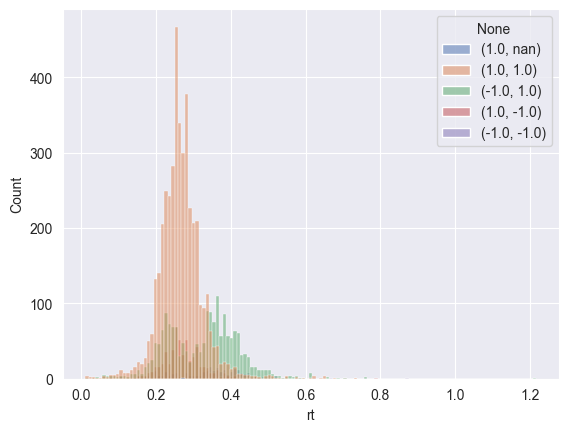

In [52]:
sns.histplot(
    test_df,
    x='rt',
    hue=test_df[['condition', 'pre_acc']].apply(tuple, axis=1),
)

In [53]:
print(f"Mean post error RT: {np.mean(test_df[test_df['pre_acc'] == -1]['rt'])}")
print(f"Mean post correct RT: {np.mean(test_df[test_df['pre_acc'] == 1]['rt'])}")

print(f"Mean incongruent post error RT: {np.mean(test_df[(test_df['pre_acc'] == -1) & (test_df['condition'] == -1)]['rt'])}")
print(f"Mean incongruent post correct RT: {np.mean(test_df[(test_df['pre_acc'] == 1) & (test_df['condition'] == -1)]['rt'])}")

print(f"Mean congruent post error RT: {np.mean(test_df[(test_df['pre_acc'] == -1) & (test_df['condition'] == 1)]['rt'])}")
print(f"Mean congruent post correct RT: {np.mean(test_df[(test_df['pre_acc'] == 1) & (test_df['condition'] == 1)]['rt'])}")

Mean post error RT: 0.296168184805033
Mean post correct RT: 0.28357284426492757
Mean incongruent post error RT: 0.3436974541412737
Mean incongruent post correct RT: 0.3229703260447881
Mean congruent post error RT: 0.27654902181477126
Mean congruent post correct RT: 0.26663517541964005


In [54]:
from scipy.stats import ttest_ind

print(f"post error vs post correct : {ttest_ind(test_df[test_df['pre_acc'] == -1]['rt'], test_df[test_df['pre_acc'] == 1]['rt'])}")
print(f"post error vs post correct in incongruent: {ttest_ind(test_df[(test_df['pre_acc'] == -1) & (test_df['condition'] == -1)]['rt'], test_df[(test_df['pre_acc'] == 1) & (test_df['condition'] == -1)]['rt'])}")

print(f"post error vs post correct in congruent: {ttest_ind(test_df[(test_df['pre_acc'] == -1) & (test_df['condition'] == 1)]['rt'], test_df[(test_df['pre_acc'] == 1) & (test_df['condition'] == 1)]['rt'])}")


post error vs post correct : TtestResult(statistic=4.3130937014174515, pvalue=1.6323349584133677e-05, df=6886.0)
post error vs post correct in incongruent: TtestResult(statistic=3.0580959412696336, pvalue=0.0022561130943944824, df=2062.0)
post error vs post correct in congruent: TtestResult(statistic=3.7146064756188513, pvalue=0.00020582243011087062, df=4822.0)


#### Test ERN vs CRN

In [55]:
df_no_nans = test_df.dropna()

# check dataframe
display(df_no_nans.isnull().any())
display(df_no_nans)

trial_number         False
ID                   False
participant_index    False
condition            False
condition_index      False
rt                   False
acc                  False
ne_Fz                False
ne_FCz               False
ne_mean_Fz           False
ne_mean_FCz          False
y                    False
pre_ne_Fz            False
pre_ne_FCz           False
pre_ne_mean_Fz       False
pre_ne_mean_FCz      False
pre_acc              False
is_in_sequence       False
dtype: bool

,trial_number,ID,participant_index,condition,condition_index,rt,acc,ne_Fz,ne_FCz,ne_mean_Fz,ne_mean_FCz,y,pre_ne_Fz,pre_ne_FCz,pre_ne_mean_Fz,pre_ne_mean_FCz,pre_acc,is_in_sequence
1,2,169,1,1,1,0.309487,1,-0.501844,-2.783326,3.766289,9.476191,0.309487,-10.473746,-13.920862,-6.156650,-5.222685,1.0,False
2,3,169,1,-1,2,0.397239,1,-3.449400,-3.684688,-1.556821,2.632504,0.397239,-0.501844,-2.783326,3.766289,9.476191,1.0,False
3,4,169,1,1,1,0.309485,1,0.790637,0.747574,4.928352,6.436701,0.309485,-3.449400,-3.684688,-1.556821,2.632504,1.0,True
4,5,169,1,-1,2,0.386673,1,-2.980749,-5.791032,-0.957992,-1.689976,0.386673,0.790637,0.747574,4.928352,6.436701,1.0,True
5,6,169,1,1,1,0.316943,1,2.572565,-1.050971,4.401086,7.993626,0.316943,-2.980749,-5.791032,-0.957992,-1.689976,1.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6884,296,208,23,-1,2,0.239623,-1,8.320652,4.675662,12.951381,12.453468,-0.239623,7.714413,8.938596,15.386128,15.872547,1.0,True
6885,297,208,23,-1,2,0.382499,1,2.655430,4.103194,5.651438,9.170830,0.382499,8.320652,4.675662,12.951381,12.453468,-1.0,True
6886,298,208,23,1,1,0.236665,1,-5.139061,-4.319686,-0.687883,-0.221055,0.236665,2.655430,4.103194,5.651438,9.170830,1.0,False
6887,299,208,23,1,1,0.261338,1,1.264665,0.551756,3.307084,4.809125,0.261338,-5.139061,-4.319686,-0.687883,-0.221055,1.0,False


In [56]:
threshold = 0.1
df_rts_truncated = df_no_nans[df_no_nans['rt'] > threshold]

df_rts_truncated

,trial_number,ID,participant_index,condition,condition_index,rt,acc,ne_Fz,ne_FCz,ne_mean_Fz,ne_mean_FCz,y,pre_ne_Fz,pre_ne_FCz,pre_ne_mean_Fz,pre_ne_mean_FCz,pre_acc,is_in_sequence
1,2,169,1,1,1,0.309487,1,-0.501844,-2.783326,3.766289,9.476191,0.309487,-10.473746,-13.920862,-6.156650,-5.222685,1.0,False
2,3,169,1,-1,2,0.397239,1,-3.449400,-3.684688,-1.556821,2.632504,0.397239,-0.501844,-2.783326,3.766289,9.476191,1.0,False
3,4,169,1,1,1,0.309485,1,0.790637,0.747574,4.928352,6.436701,0.309485,-3.449400,-3.684688,-1.556821,2.632504,1.0,True
4,5,169,1,-1,2,0.386673,1,-2.980749,-5.791032,-0.957992,-1.689976,0.386673,0.790637,0.747574,4.928352,6.436701,1.0,True
5,6,169,1,1,1,0.316943,1,2.572565,-1.050971,4.401086,7.993626,0.316943,-2.980749,-5.791032,-0.957992,-1.689976,1.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6884,296,208,23,-1,2,0.239623,-1,8.320652,4.675662,12.951381,12.453468,-0.239623,7.714413,8.938596,15.386128,15.872547,1.0,True
6885,297,208,23,-1,2,0.382499,1,2.655430,4.103194,5.651438,9.170830,0.382499,8.320652,4.675662,12.951381,12.453468,-1.0,True
6886,298,208,23,1,1,0.236665,1,-5.139061,-4.319686,-0.687883,-0.221055,0.236665,2.655430,4.103194,5.651438,9.170830,1.0,False
6887,299,208,23,1,1,0.261338,1,1.264665,0.551756,3.307084,4.809125,0.261338,-5.139061,-4.319686,-0.687883,-0.221055,1.0,False


In [57]:
# df_rts_truncated['pre_ne_FCz_centered'] = (df_rts_truncated['pre_ne_FCz'] - np.mean(df_rts_truncated['pre_ne_FCz'])) / np.std(df_rts_truncated['pre_ne_FCz'])

y = df_rts_truncated['y'].to_numpy()
condition = df_rts_truncated['condition'].to_numpy()
pre_acc = df_rts_truncated['pre_acc'].to_numpy()
# pre_ne = df_rts_truncated['pre_ne_FCz_centered'].to_numpy()
participant_index = df_rts_truncated['participant_index'].to_numpy()

n_participants = len(np.unique(participant_index))
n_conditions = len(np.unique(condition))

participants_trials_slices = []
pre_ne = []
for index in np.unique(participant_index):
    indices = np.where(participant_index == index)[0]
    start_index = indices[0] + 1
    end_index = indices[-1] + 1
    participants_trials_slices.append([start_index, end_index])

    participants_ne = df_rts_truncated.iloc[indices]['pre_ne_FCz'].to_numpy().flatten()
    participants_ne_stand = (participants_ne - np.mean(participants_ne)) / np.std(participants_ne)

    pre_ne.extend(participants_ne_stand)

participants_trials_slices = np.array(participants_trials_slices)
pre_ne = np.array(pre_ne)
df_rts_truncated['pre_ne_FCz_centered'] = pre_ne

/var/folders/1_/b6g54cj10qj9pmtdn3v29ryc0000gn/T/ipykernel_20149/3074861894.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rts_truncated['pre_ne_FCz_centered'] = pre_ne


Group-level stats and distributions

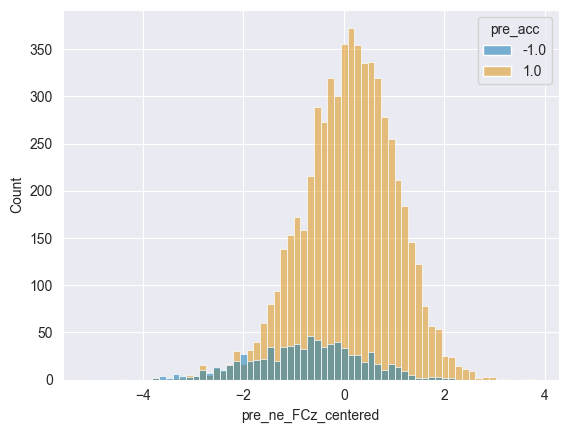

In [58]:
plt.figure()

sns.histplot(
    df_rts_truncated,
    x="pre_ne_FCz_centered",
    hue='pre_acc',
    palette='colorblind'
)

plt.show()

In [59]:
test_2 = df_rts_truncated.dropna()
ttest_ind(test_2[test_2['pre_acc'] == -1]['pre_ne_FCz'], test_2[test_2['pre_acc'] == 1]['pre_ne_FCz'])

TtestResult(statistic=-21.39845883149973, pvalue=2.254504704658183e-98, df=6813.0)

Participant-level stats and distributions

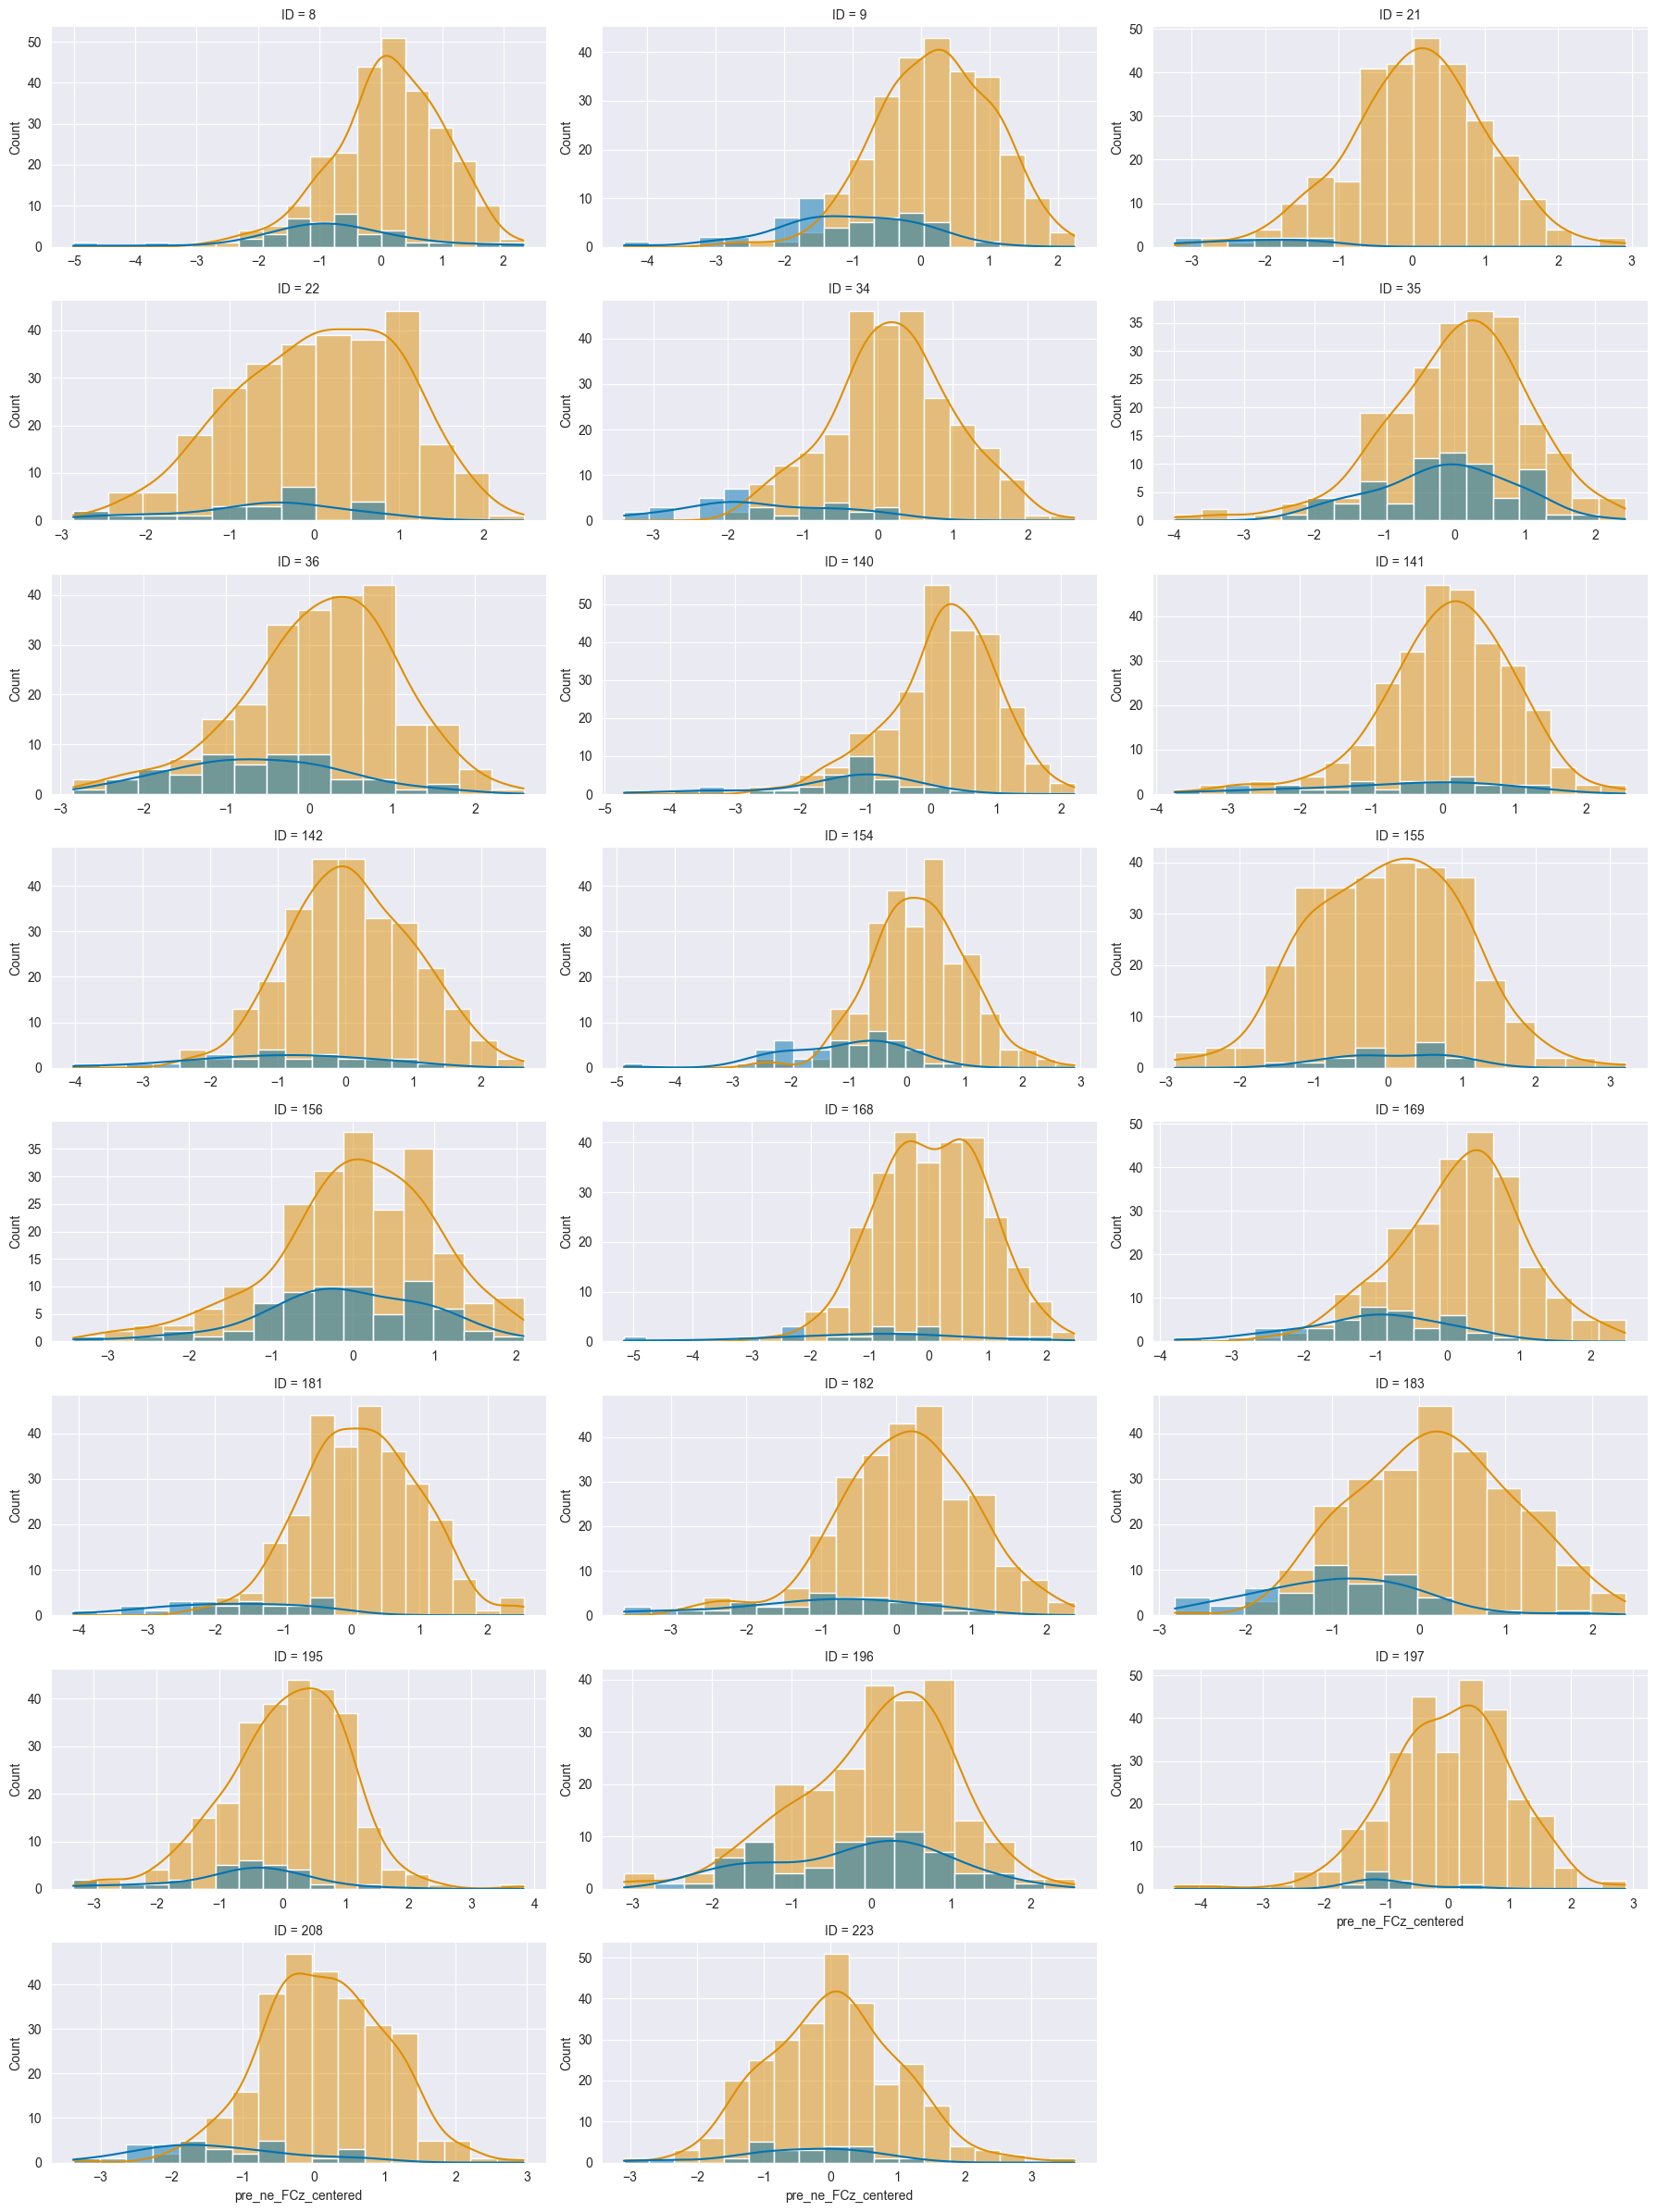

In [60]:
g = sns.FacetGrid(
    df_rts_truncated.sort_values(['ID']),
    col="ID",
    col_wrap=3,
    sharex=False,
    sharey=False,
    aspect=2,
)

g.map_dataframe(
    sns.histplot,
    x="pre_ne_FCz_centered",
    hue='pre_acc',
    kde=True,
    palette='colorblind'
)

#### Test post-response adaptation and links with pre-trial accuracy and brain signal

In [61]:
import statsmodels.formula.api as smf

test_df2 = test_df.dropna()
test_df2['rt'] = test_df2['rt']*1000
mod = smf.ols(formula='rt ~ pre_acc', data=test_df2)
res = mod.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     rt   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     18.09
Date:                Thu, 25 Jan 2024   Prob (F-statistic):           2.13e-05
Time:                        12:31:09   Log-Likelihood:                -39715.
No. Observations:                6870   AIC:                         7.943e+04
Df Residuals:                    6868   BIC:                         7.945e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    289.7850      1.464    197.970      0.0

/var/folders/1_/b6g54cj10qj9pmtdn3v29ryc0000gn/T/ipykernel_20149/2184364754.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df2['rt'] = test_df2['rt']*1000


In [62]:
import statsmodels.formula.api as smf

test_df2 = test_df.dropna()
test_df2['rt'] = test_df2['rt']*1000
test_df2['pre_ne_FCz_centered'] = test_df2['pre_ne_FCz'] - np.mean(test_df2['pre_ne_FCz'])

mod = smf.ols(formula='rt ~ pre_ne_FCz_centered*condition', data=test_df2)
res = mod.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     rt   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.119
Method:                 Least Squares   F-statistic:                     308.9
Date:                Thu, 25 Jan 2024   Prob (F-statistic):          3.99e-188
Time:                        12:31:09   Log-Likelihood:                -39289.
No. Observations:                6870   AIC:                         7.859e+04
Df Residuals:                    6866   BIC:                         7.861e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

/var/folders/1_/b6g54cj10qj9pmtdn3v29ryc0000gn/T/ipykernel_20149/1119672488.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df2['rt'] = test_df2['rt']*1000
/var/folders/1_/b6g54cj10qj9pmtdn3v29ryc0000gn/T/ipykernel_20149/1119672488.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df2['pre_ne_FCz_centered'] = test_df2['pre_ne_FCz'] - np.mean(test_df2['pre_ne_FCz'])


In [63]:
import statsmodels.formula.api as smf

test_df2 = test_df.dropna()
test_df2['rt'] = test_df2['rt']*1000
test_df2['pre_ne_FCz_centered'] = test_df2['pre_ne_FCz'] - np.mean(test_df2['pre_ne_FCz'])

mod = smf.ols(formula='rt ~ pre_ne_FCz_centered + pre_ne_FCz_centered*condition + C(pre_acc) + C(pre_acc)*condition + pre_ne_FCz_centered*C(pre_acc) + pre_ne_FCz_centered*C(pre_acc)*condition', data=test_df2)
res = mod.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     rt   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                     136.6
Date:                Thu, 25 Jan 2024   Prob (F-statistic):          4.95e-189
Time:                        12:31:09   Log-Likelihood:                -39276.
No. Observations:                6870   AIC:                         7.857e+04
Df Residuals:                    6862   BIC:                         7.862e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

/var/folders/1_/b6g54cj10qj9pmtdn3v29ryc0000gn/T/ipykernel_20149/673595589.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df2['rt'] = test_df2['rt']*1000
/var/folders/1_/b6g54cj10qj9pmtdn3v29ryc0000gn/T/ipykernel_20149/673595589.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df2['pre_ne_FCz_centered'] = test_df2['pre_ne_FCz'] - np.mean(test_df2['pre_ne_FCz'])


In [64]:
test_df.to_csv('data/twentythree_participants_post_eeg_many_test_set.csv')

---

## Test EEG

In [65]:
df_no_nans = test_df.dropna()

# check dataframe
display(df_no_nans.isnull().any())
display(df_no_nans)

trial_number         False
ID                   False
participant_index    False
condition            False
condition_index      False
rt                   False
acc                  False
ne_Fz                False
ne_FCz               False
ne_mean_Fz           False
ne_mean_FCz          False
y                    False
pre_ne_Fz            False
pre_ne_FCz           False
pre_ne_mean_Fz       False
pre_ne_mean_FCz      False
pre_acc              False
is_in_sequence       False
dtype: bool

,trial_number,ID,participant_index,condition,condition_index,rt,acc,ne_Fz,ne_FCz,ne_mean_Fz,ne_mean_FCz,y,pre_ne_Fz,pre_ne_FCz,pre_ne_mean_Fz,pre_ne_mean_FCz,pre_acc,is_in_sequence
1,2,169,1,1,1,0.309487,1,-0.501844,-2.783326,3.766289,9.476191,0.309487,-10.473746,-13.920862,-6.156650,-5.222685,1.0,False
2,3,169,1,-1,2,0.397239,1,-3.449400,-3.684688,-1.556821,2.632504,0.397239,-0.501844,-2.783326,3.766289,9.476191,1.0,False
3,4,169,1,1,1,0.309485,1,0.790637,0.747574,4.928352,6.436701,0.309485,-3.449400,-3.684688,-1.556821,2.632504,1.0,True
4,5,169,1,-1,2,0.386673,1,-2.980749,-5.791032,-0.957992,-1.689976,0.386673,0.790637,0.747574,4.928352,6.436701,1.0,True
5,6,169,1,1,1,0.316943,1,2.572565,-1.050971,4.401086,7.993626,0.316943,-2.980749,-5.791032,-0.957992,-1.689976,1.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6884,296,208,23,-1,2,0.239623,-1,8.320652,4.675662,12.951381,12.453468,-0.239623,7.714413,8.938596,15.386128,15.872547,1.0,True
6885,297,208,23,-1,2,0.382499,1,2.655430,4.103194,5.651438,9.170830,0.382499,8.320652,4.675662,12.951381,12.453468,-1.0,True
6886,298,208,23,1,1,0.236665,1,-5.139061,-4.319686,-0.687883,-0.221055,0.236665,2.655430,4.103194,5.651438,9.170830,1.0,False
6887,299,208,23,1,1,0.261338,1,1.264665,0.551756,3.307084,4.809125,0.261338,-5.139061,-4.319686,-0.687883,-0.221055,1.0,False


In [66]:
threshold = 0.1
df_rts_truncated = df_no_nans[df_no_nans['rt'] > threshold]

df_rts_truncated

,trial_number,ID,participant_index,condition,condition_index,rt,acc,ne_Fz,ne_FCz,ne_mean_Fz,ne_mean_FCz,y,pre_ne_Fz,pre_ne_FCz,pre_ne_mean_Fz,pre_ne_mean_FCz,pre_acc,is_in_sequence
1,2,169,1,1,1,0.309487,1,-0.501844,-2.783326,3.766289,9.476191,0.309487,-10.473746,-13.920862,-6.156650,-5.222685,1.0,False
2,3,169,1,-1,2,0.397239,1,-3.449400,-3.684688,-1.556821,2.632504,0.397239,-0.501844,-2.783326,3.766289,9.476191,1.0,False
3,4,169,1,1,1,0.309485,1,0.790637,0.747574,4.928352,6.436701,0.309485,-3.449400,-3.684688,-1.556821,2.632504,1.0,True
4,5,169,1,-1,2,0.386673,1,-2.980749,-5.791032,-0.957992,-1.689976,0.386673,0.790637,0.747574,4.928352,6.436701,1.0,True
5,6,169,1,1,1,0.316943,1,2.572565,-1.050971,4.401086,7.993626,0.316943,-2.980749,-5.791032,-0.957992,-1.689976,1.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6884,296,208,23,-1,2,0.239623,-1,8.320652,4.675662,12.951381,12.453468,-0.239623,7.714413,8.938596,15.386128,15.872547,1.0,True
6885,297,208,23,-1,2,0.382499,1,2.655430,4.103194,5.651438,9.170830,0.382499,8.320652,4.675662,12.951381,12.453468,-1.0,True
6886,298,208,23,1,1,0.236665,1,-5.139061,-4.319686,-0.687883,-0.221055,0.236665,2.655430,4.103194,5.651438,9.170830,1.0,False
6887,299,208,23,1,1,0.261338,1,1.264665,0.551756,3.307084,4.809125,0.261338,-5.139061,-4.319686,-0.687883,-0.221055,1.0,False


In [67]:
# df_rts_truncated['pre_ne_FCz_centered'] = (df_rts_truncated['pre_ne_FCz'] - np.mean(df_rts_truncated['pre_ne_FCz'])) / np.std(df_rts_truncated['pre_ne_FCz'])

y = df_rts_truncated['y'].to_numpy()
condition = df_rts_truncated['condition'].to_numpy()
pre_acc = df_rts_truncated['pre_acc'].to_numpy()
# pre_ne = df_rts_truncated['pre_ne_FCz_centered'].to_numpy()
participant_index = df_rts_truncated['participant_index'].to_numpy()

n_participants = len(np.unique(participant_index))
n_conditions = len(np.unique(condition))

participants_trials_slices = []
pre_ne = []
for index in np.unique(participant_index):
    indices = np.where(participant_index == index)[0]
    start_index = indices[0] + 1
    end_index = indices[-1] + 1
    participants_trials_slices.append([start_index, end_index])

    participants_ne = df_rts_truncated.iloc[indices]['pre_ne_FCz'].to_numpy().flatten()
    participants_ne_stand = (participants_ne - np.mean(participants_ne)) / np.std(participants_ne)

    pre_ne.extend(participants_ne_stand)

participants_trials_slices = np.array(participants_trials_slices)
pre_ne = np.array(pre_ne)
df_rts_truncated['pre_ne_FCz_centered'] = pre_ne

/var/folders/1_/b6g54cj10qj9pmtdn3v29ryc0000gn/T/ipykernel_20149/3074861894.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rts_truncated['pre_ne_FCz_centered'] = pre_ne


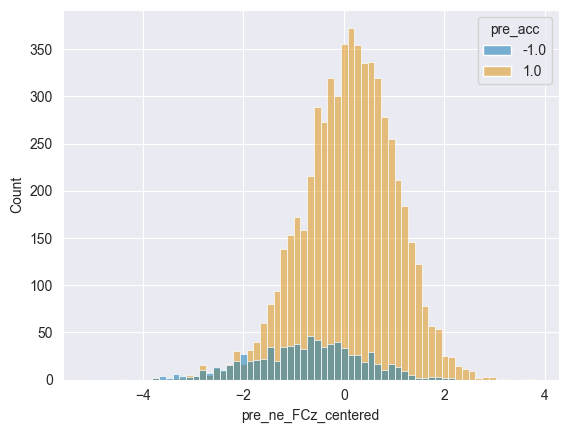

In [68]:
plt.figure()

sns.histplot(
    df_rts_truncated,
    x="pre_ne_FCz_centered",
    hue='pre_acc',
    palette='colorblind'
)

plt.show()

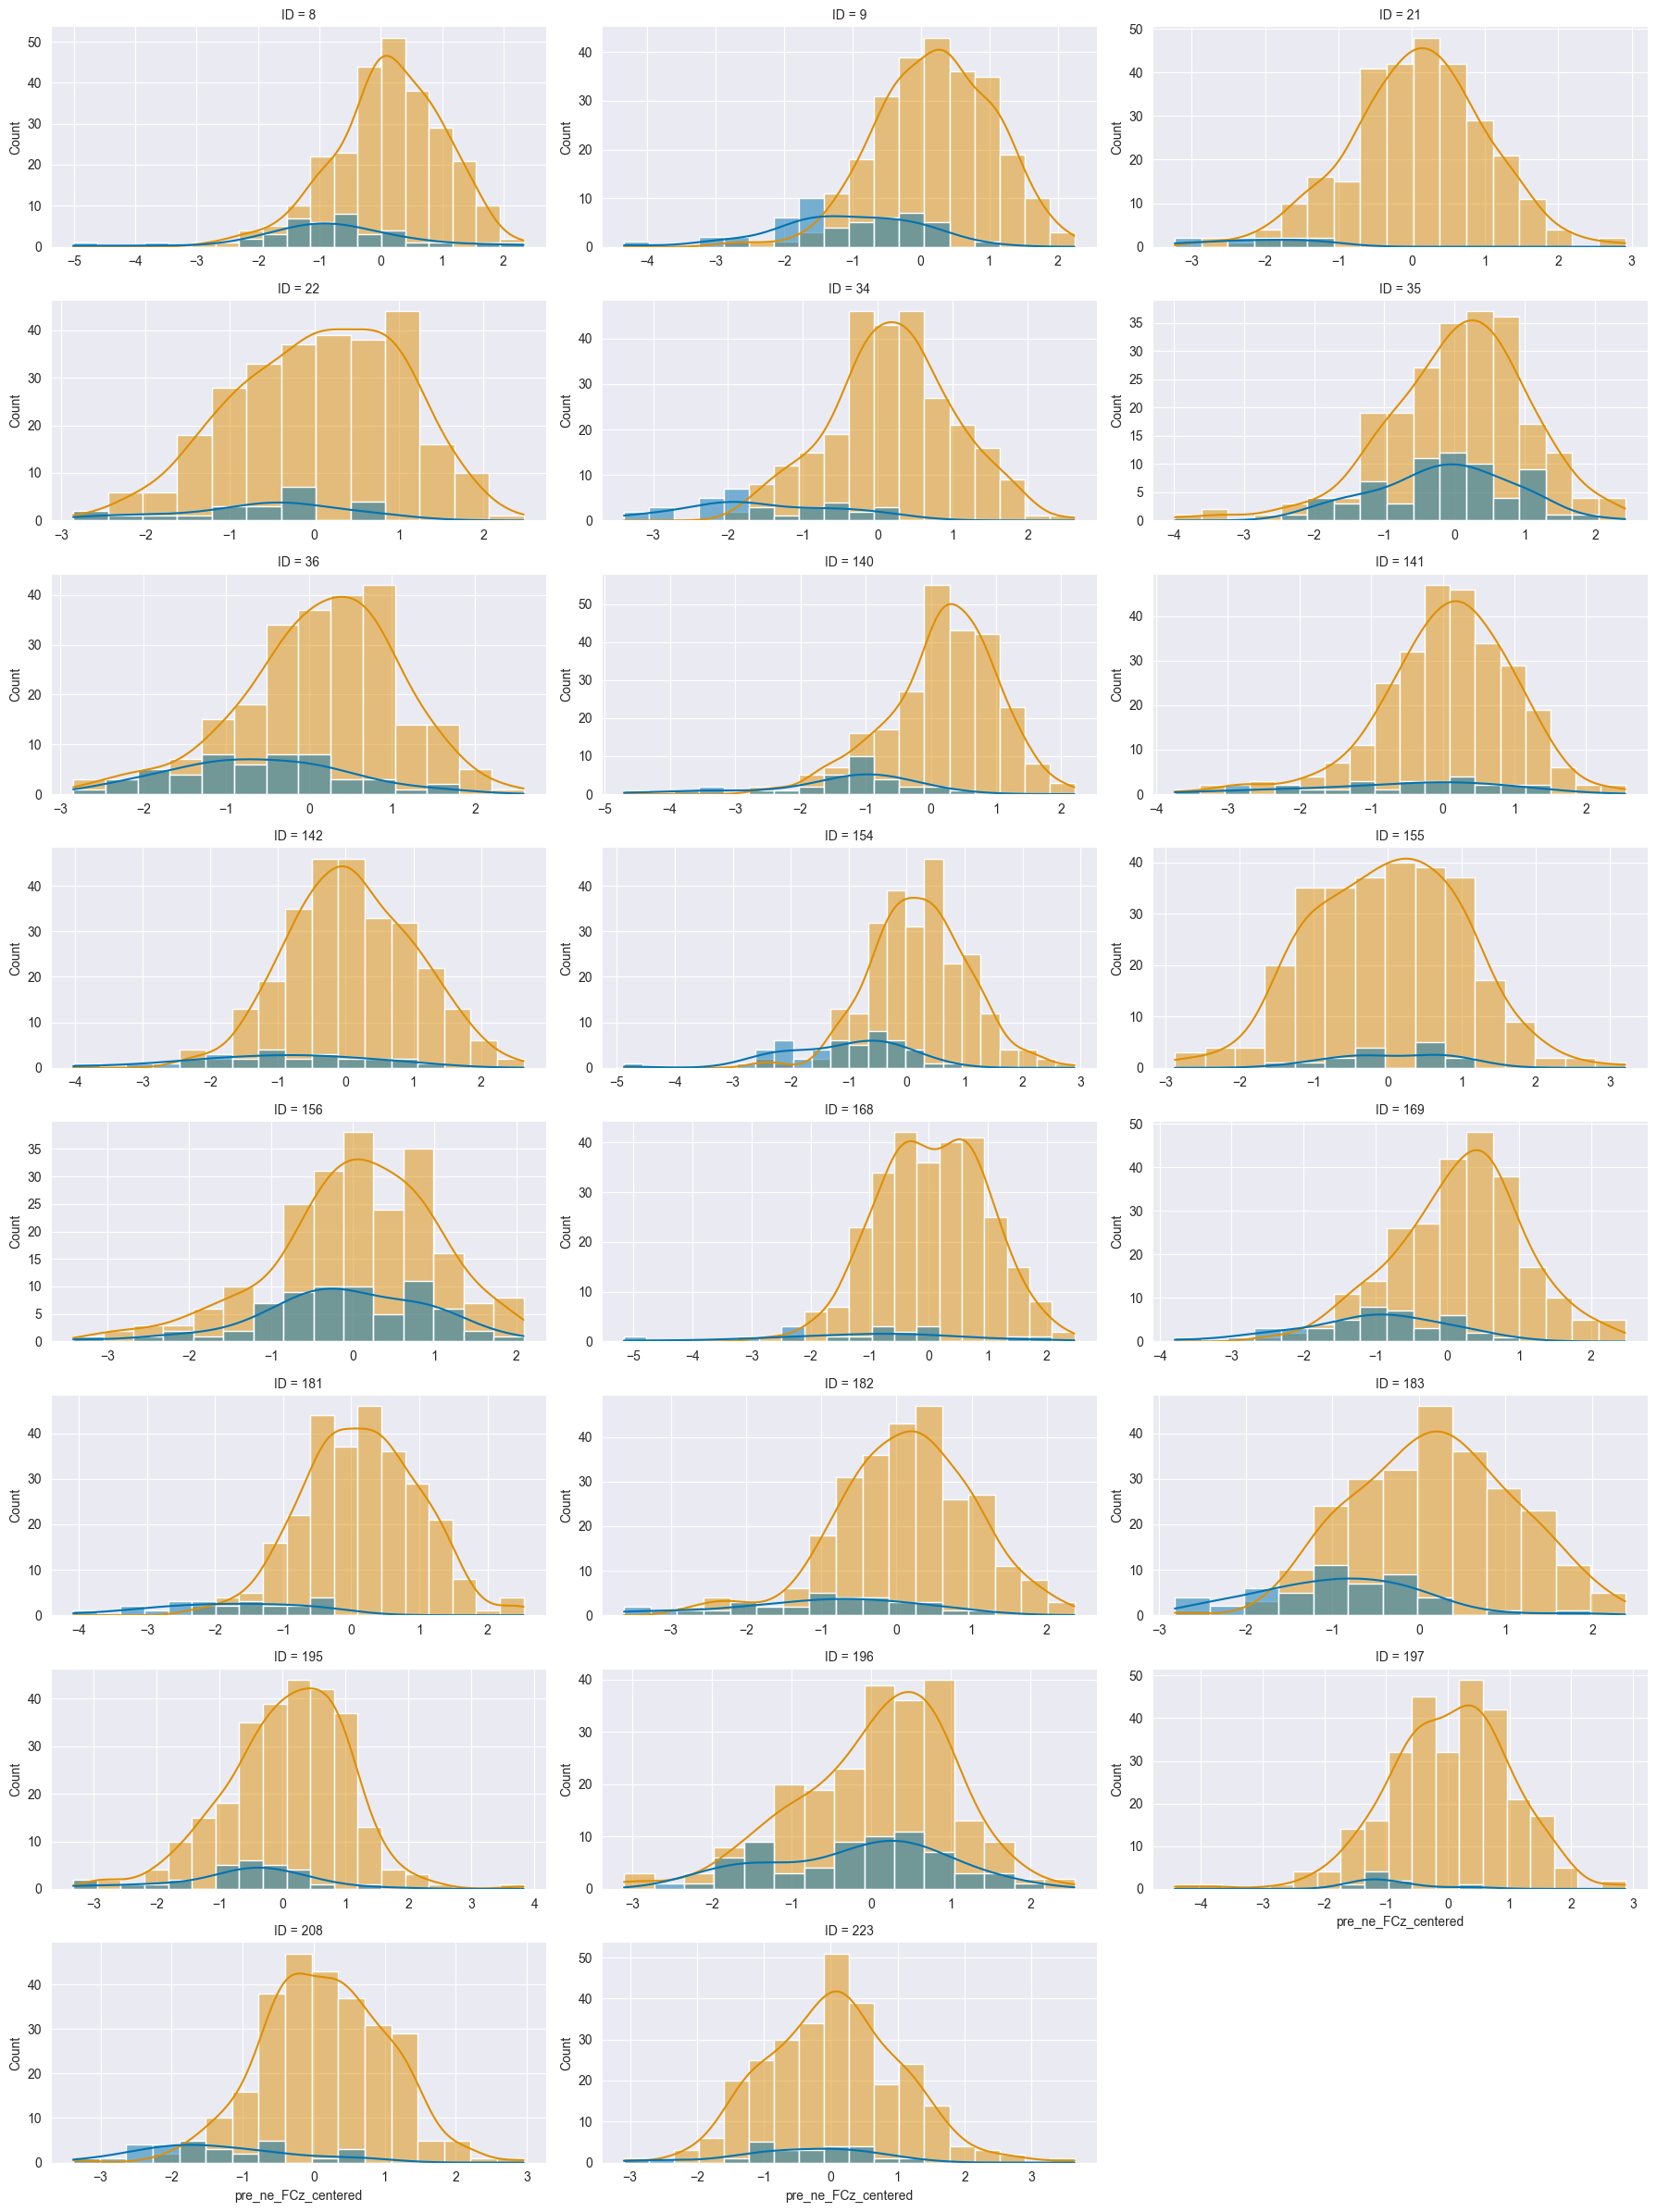

In [69]:
g = sns.FacetGrid(
    df_rts_truncated.sort_values(['ID']),
    col="ID",
    col_wrap=3,
    sharex=False,
    sharey=False,
    aspect=2,
)

g.map_dataframe(
    sns.histplot,
    x="pre_ne_FCz_centered",
    hue='pre_acc',
    kde=True,
    palette='colorblind'
)